In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [26]:
df_confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,333,361,377,383,400,409,416,433,446,467


In [27]:
df_covid19.head(2)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Australia,2020-04-14 00:25:33,-25.0000,133.0000,6351,61,1806,4484,24.945306,NaN,NaN,0.960479,36,AUS
1,Austria,2020-04-14 00:17:49,47.5162,14.5501,14041,368,7343,6330,155.900249,NaN,NaN,2.620896,40,AUT


In [28]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

In [29]:
df_covid19.head()

,country,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Australia,2020-04-14 00:25:33,-25.0000,133.0000,6351,61,1806,4484,24.945306,NaN,NaN,0.960479,36,AUS
1,Austria,2020-04-14 00:17:49,47.5162,14.5501,14041,368,7343,6330,155.900249,NaN,NaN,2.620896,40,AUT
2,Canada,2020-04-14 00:25:16,60.0010,-95.0010,25680,780,7758,17142,67.836544,NaN,NaN,3.037383,124,CAN
3,China,2020-04-13 15:28:25,30.5928,114.3055,83213,3345,78039,1829,5.923998,NaN,NaN,4.019805,156,CHN
4,Denmark,2020-04-14 00:17:49,56.0000,10.0000,6513,285,2403,3825,112.444263,NaN,NaN,4.375864,208,DNK


In [30]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent",5)
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(n)] for n in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)]+"1000" for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [31]:
df_confirmed.shape

(264, 88)

In [32]:
df_table.insert(1,"cnent",  [continents[country_to_continent_code(country)]+"1000" for country in df_table["Country_Region"].values])

In [33]:
df_table.head()

,Country_Region,cnent,continent,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String
0,Afghanistan,Asia1000,Asia1000,2020-01-22,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/22
1,Afghanistan,Asia1000,Asia1000,2020-01-23,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/23
2,Afghanistan,Asia1000,Asia1000,2020-01-24,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/24
3,Afghanistan,Asia1000,Asia1000,2020-01-25,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/25
4,Afghanistan,Asia1000,Asia1000,2020-01-26,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/26


In [35]:
df_confirmed.head()

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,5,33.0000,65.0000,0,0,0,0,0,...,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,5,41.1533,20.1683,0,0,0,0,0,...,333,361,377,383,400,409,416,433,446,467
2,NaN,Algeria,5,28.0339,1.6596,0,0,0,0,0,...,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,NaN,Andorra,5,42.5063,1.5218,0,0,0,0,0,...,466,501,525,545,564,583,601,601,638,646
4,NaN,Angola,5,-11.2027,17.8739,0,0,0,0,0,...,10,14,16,17,19,19,19,19,19,19


In [36]:
df_covid19.head()

,country,continent,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Australia,Australia,2020-04-14 00:25:33,-25.0000,133.0000,6351,61,1806,4484,24.945306,NaN,NaN,0.960479,36,AUS
1,Austria,Europe,2020-04-14 00:17:49,47.5162,14.5501,14041,368,7343,6330,155.900249,NaN,NaN,2.620896,40,AUT
2,Canada,North America,2020-04-14 00:25:16,60.0010,-95.0010,25680,780,7758,17142,67.836544,NaN,NaN,3.037383,124,CAN
3,China,Asia,2020-04-13 15:28:25,30.5928,114.3055,83213,3345,78039,1829,5.923998,NaN,NaN,4.019805,156,CHN
4,Denmark,Europe,2020-04-14 00:17:49,56.0000,10.0000,6513,285,2403,3825,112.444263,NaN,NaN,4.375864,208,DNK


In [ ]:
islam=[1,2,3,4,5,6]
print(islam[:])

In [38]:
df_table = df_table[df_table["continent"] != "Others"]
df_table

,Country_Region,cnent,continent,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String
0,Afghanistan,Asia1000,Asia1000,2020-01-22,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/22
1,Afghanistan,Asia1000,Asia1000,2020-01-23,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/23
2,Afghanistan,Asia1000,Asia1000,2020-01-24,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/24
3,Afghanistan,Asia1000,Asia1000,2020-01-25,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/25
4,Afghanistan,Asia1000,Asia1000,2020-01-26,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/26
5,Afghanistan,Asia1000,Asia1000,2020-01-27,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/27
6,Afghanistan,Asia1000,Asia1000,2020-01-28,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/28
7,Afghanistan,Asia1000,Asia1000,2020-01-29,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/29
8,Afghanistan,Asia1000,Asia1000,2020-01-30,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/30
9,Afghanistan,Asia1000,Asia1000,2020-01-31,0,0,NaN,NaN,0,NaN,0.000000,NaN,NaN,NaN,NaN,4,AFG,2020/01/31


In [40]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

In [52]:
df_covid19.head(15)

,country,continent,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Australia,Australia,2020-04-14 00:25:33,-25.0000,133.0000,6351,61,1806,4484,24.945306,NaN,NaN,0.960479,36,AUS
1,Austria,Europe,2020-04-14 00:17:49,47.5162,14.5501,14041,368,7343,6330,155.900249,NaN,NaN,2.620896,40,AUT
2,Canada,North America,2020-04-14 00:25:16,60.0010,-95.0010,25680,780,7758,17142,67.836544,NaN,NaN,3.037383,124,CAN
3,China,Asia,2020-04-13 15:28:25,30.5928,114.3055,83213,3345,78039,1829,5.923998,NaN,NaN,4.019805,156,CHN
4,Denmark,Europe,2020-04-14 00:17:49,56.0000,10.0000,6513,285,2403,3825,112.444263,NaN,NaN,4.375864,208,DNK
5,Finland,Europe,2020-04-14 00:17:49,61.9241,25.7482,3064,59,300,2705,55.299692,NaN,NaN,1.925587,246,FIN
6,France,Europe,2020-04-14 00:17:49,46.2276,2.2137,137877,14986,28001,94890,211.229633,NaN,NaN,10.869108,250,FRA
7,Germany,Europe,2020-04-14 00:17:49,51.1657,10.4515,130072,3194,64300,62578,155.246927,NaN,NaN,2.455563,276,DEU
8,Iceland,Europe,2020-04-14 00:17:49,64.9631,-19.0208,1711,8,933,770,501.391941,NaN,NaN,0.467563,352,ISL
9,Ireland,Europe,2020-04-14 00:17:49,53.1424,-7.6921,10647,365,25,10257,215.622517,NaN,NaN,3.428196,372,IRL


In [41]:

df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

In [42]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["Confirmed"],2)
df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.0f}",subset=["Confirmed"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Mortality Rate (per 100)
0,1918855,119588,448998,1.35027e+06,9750.82,0,0,722.768,96167,6.23


In [43]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Mortality Rate (per 100)
continent,,,,,,,,,,
Africa,15340,835,2946,11559,126.574,0,0,242.079,24164,5.44
Asia,309864,11345,150514,148005,882.609,0,0,84.4049,17692,3.66
Australia,7718,66,2352,5300,54.7271,0,0,1.33112,1430,0.86
Europe,908789,80025,231580,597184,6979.34,0,0,185.125,18538,8.81
North America,621151,25043,53857,542251,535.339,0,0,112.561,8292,4.03
Others,1392,26,740,626,1011.97,0,0,33.3416,21343,1.87
South America,54601,2248,7009,45344,160.261,0,0,63.9264,4708,4.12


In [44]:
# df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Wistia')
df_countries_cases["Mortality Rate (per 100)"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)
df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Mortality Rate (per 100)
country,,,,,,,,,,,
USA,581679,23604,43738,514337,176.552,nan,nan,4.05791,840,USA,4.06
Spain,170099,17756,64727,87616,363.811,nan,nan,10.4386,724,ESP,10.44
Italy,159516,20465,35435,103616,263.829,nan,nan,12.8294,380,ITA,12.83
France,137877,14986,28001,94890,211.23,nan,nan,10.8691,250,FRA,10.87
Germany,130072,3194,64300,62578,155.247,nan,nan,2.45556,276,DEU,2.46
United Kingdom,89571,11347,313,77911,131.943,nan,nan,12.6682,826,GBR,12.67
China,83213,3345,78039,1829,5.924,nan,nan,4.0198,156,CHN,4.02
Iran,73303,4585,45983,22735,87.2728,nan,nan,6.25486,364,IRN,6.25
Turkey,61049,1296,3957,55796,72.3852,nan,nan,2.12288,792,TUR,2.12


In [ ]:
	Confirmed

In [45]:
# df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Wistia')
df_countries_cases["Mortality Rate (per 100)"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)
df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Mortality Rate (per 100)
country,,,,,,,,,,,
USA,581679,23604,43738,514337,176.552,nan,nan,4.05791,840,USA,4.06
Spain,170099,17756,64727,87616,363.811,nan,nan,10.4386,724,ESP,10.44
Italy,159516,20465,35435,103616,263.829,nan,nan,12.8294,380,ITA,12.83
France,137877,14986,28001,94890,211.23,nan,nan,10.8691,250,FRA,10.87
Germany,130072,3194,64300,62578,155.247,nan,nan,2.45556,276,DEU,2.46
United Kingdom,89571,11347,313,77911,131.943,nan,nan,12.6682,826,GBR,12.67
China,83213,3345,78039,1829,5.924,nan,nan,4.0198,156,CHN,4.02
Iran,73303,4585,45983,22735,87.2728,nan,nan,6.25486,364,IRN,6.25
Turkey,61049,1296,3957,55796,72.3852,nan,nan,2.12288,792,TUR,2.12


In [50]:
df_countries_cases.head()

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Mortality Rate (per 100)
country,,,,,,,,,,,
Australia,6351,61,1806,4484,24.945306,NaN,NaN,0.960479,36,AUS,0.96
Austria,14041,368,7343,6330,155.900249,NaN,NaN,2.620896,40,AUT,2.62
Canada,25680,780,7758,17142,67.836544,NaN,NaN,3.037383,124,CAN,3.04
China,83213,3345,78039,1829,5.923998,NaN,NaN,4.019805,156,CHN,4.02
Denmark,6513,285,2403,3825,112.444263,NaN,NaN,4.375864,208,DNK,4.38


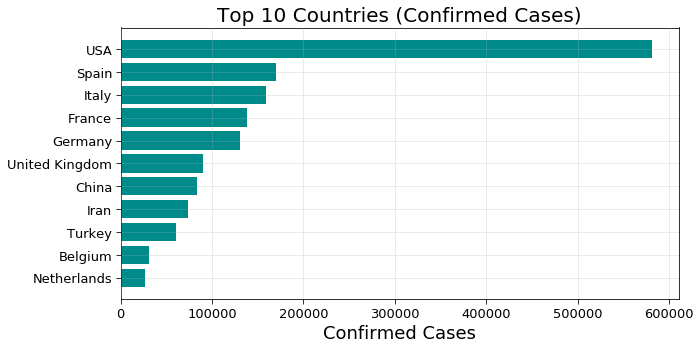

In [46]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=False)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-11:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-11:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Active Cases).png')

In [ ]:
covid_19.head()

In [54]:
df_table.head()

,Country_Region,cnent,continent,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String
0,Afghanistan,Asia1000,Asia1000,2020-01-22,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/22
1,Afghanistan,Asia1000,Asia1000,2020-01-23,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/23
2,Afghanistan,Asia1000,Asia1000,2020-01-24,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/24
3,Afghanistan,Asia1000,Asia1000,2020-01-25,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/25
4,Afghanistan,Asia1000,Asia1000,2020-01-26,0,0,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/26


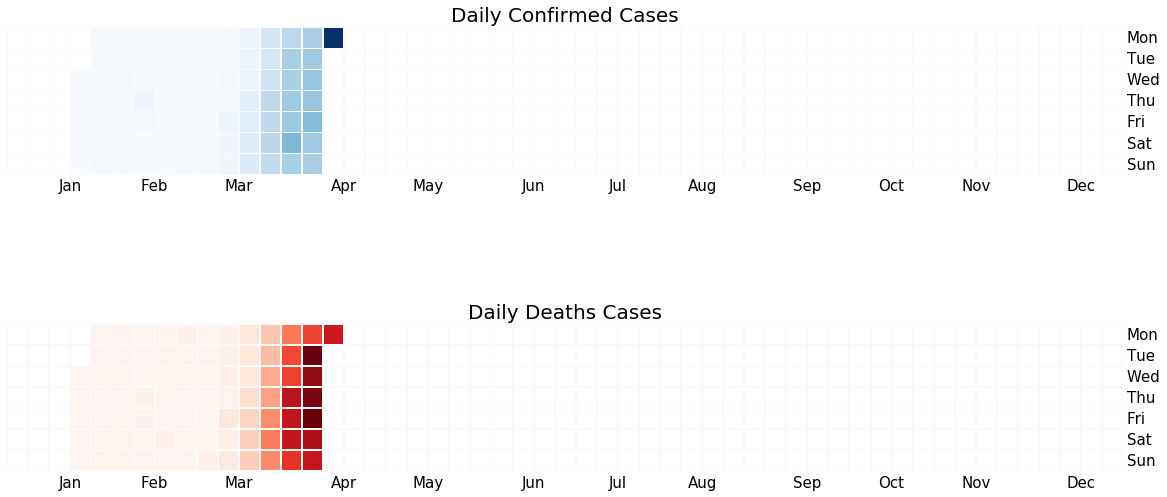

In [53]:
f = plt.figure(figsize=(20,10))
f.add_subplot(2,1,1)
calmap.yearplot(df_table.groupby('Last_Update')['Confirmed'].sum().diff(), fillcolor='white', cmap='Blues', linewidth=0.5,linecolor="#fafafa",year=2020,)
plt.title("Daily Confirmed Cases",fontsize=20)
plt.tick_params(labelsize=15)

f.add_subplot(2,1,2)
calmap.yearplot(df_table.groupby('Last_Update')['Deaths'].sum().diff(), fillcolor='white', cmap='Reds', linewidth=1,linecolor="#fafafa",year=2020,)
plt.title("Daily Deaths Cases",fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
df_countries_cases.iloc[:,:-1].corr().style.background_gradient(cmap='Reds')

In [ ]:
df_continents_cases.iloc[:,:-1].corr().style.background_gradient(cmap='Reds')

In [ ]:
df_confirmed.head()

In [ ]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#1c61f0',
        fill_color='#1c8533',
        fill=True).add_to(world_map)

world_map


print(len(df_confirmed ))


In [ ]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df["Confirmed"]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Blues")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()

In [ ]:
df_data = df_table.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index()
df_data["Last_Update"] = pd.to_datetime( df_data["Last_Update"]).dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(df_data, locations="Country_Region", locationmode='country names', 
                     color=np.power(df_data["Confirmed"],0.3)-2 , size= np.power(df_data["Confirmed"]+1,0.3)-1, hover_name="Country_Region",
                     hover_data=["Confirmed"],
                     range_color= [0, max(np.power(df_data["Confirmed"],0.3))], 
                     projection="natural earth", animation_frame="Last_Update", 
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='COVID-19: Progression of spread'
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
sorted(df_confirmed)

In [ ]:
df_confirmed.drop(['coinent','cotinent'],inplace=True,axis=1)

In [ ]:
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)
marker_style = dict(c="crimson",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=1)
plt.grid(alpha = 0.3)

plt.savefig(out+'spread.png')
plt.show()
plt.close()